# 01. PyTorch Workflow Fundamentals

Remember the essence of machine learning and deep learning is taking data from the past, building an algorithm to discover patterns and using those patterns to predict future outcomes.

Main outline of steps:
1. Get data ready (turn into tensors)
2. Build or pick pretrained system 
  2.1 Pick a loss function and optimizer
  2.2 Build a training loop
3. Fit model to data and make prediction
4. Evaluate the model
5. Imrpove through experimentation
6. Save and reload trained model

In [1]:
import torch
from torch import nn # Building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cpu'

## Data (preparing and loading)

1. Turn data (could be anything) into numbers
2. Pick or build model to learn the representation as best as possible


Example
- use linear regression to create data with known parameters
- use PyTorch to see if we can build a model to estimate parameters using **gradient descent**

In [2]:
# Known parameters
weight = 0.7
bias = 0.3

# Data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now build a model that can learn the relationship between `X` **(features)** and `y` **(labels)**.

### Split data into training and test sets

Before we build the model, we need to split the data.

**Training set**
- model learns from this data
- usually 60-80%
  
**Validation set**
- model gets tuned in on this data
- usually 10-20%
- used often, but not always

**Testing set**
- model gets evaluated on this data to test what has been learned
- 10-20%, used always

Training is kind of like studying for an exam, validation might be a practice exam and the testing set might be similar to the actual exam you take at the end.

In [3]:
train_split = int(0.8 * len(X)) # Split data 80-20
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

The model we make is going to try and learn the relationshi between `X_train` and `y_train`.

Create a function to visualize the data:

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        # Plot predictions in red
        plt.scatter(test_labels, predictions, c="r", s=4, label="Predictions")
    
    # Show the legend
    plt.legend(prop={"size": 14})

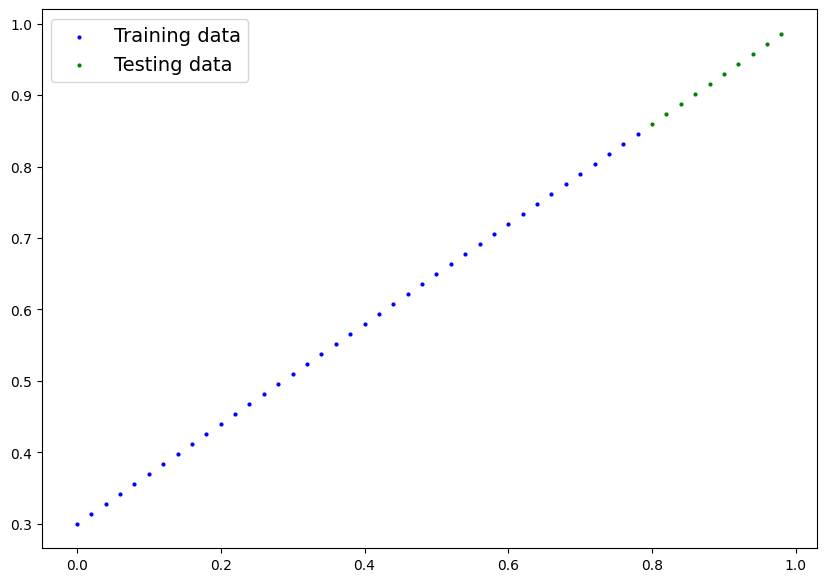

In [6]:
plot_predictions()

## 2. Build Model

Now, build a model to use the blue dots to predict the green dots.

Replicate a standard linear regression model using PyTorch:

In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Start with random weights and biases -- these will get adjusted as the model learns
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                    requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),
                                 requires_grad=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input (training/testing features)
        return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

These are the four most essential PyTorch modules used for model building:

**`torch.nn`** \
Contains all of the building blocks for computational graphs (a series of computations executed in a particular way)

**`torch.nn.Parameter`** \
Stores tensors that can be used with `nn.Module`. If `requires_grad=True`, gradients are calculated automatically. These are used for updating model parameters via *gradient descent*.

**`torch.nn.Module`** \
Base class for neural network modules, all building blocks for nns are subclasses. If you build a neural network, your models should subclass `nn.Module` -- this requires the implementation of a `forward()` method.

**`torch.optim`** \
Contains optimization algorithms that tell model parameters sotred in `torch.nn.Parameter` how to best change to improve gradient descent and reduce loss.

**`def forward()`** \
All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the module, e.g. the linear regression formula above.

**Summary**
- `nn.Module` contains larger building blocks (layers)
- `nn.Parameter` contains smaller parameters like weights and biases
- `forward()` tells larger blocks how to make calculations on inputs within the module
- `torch.optim` contains methods on how to improve the parameters to better represent the input data

### Checking contents of PyTorch model

In [10]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# Get state (what model contains)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

We start from random values (initialized above using `torch.randn()`) and get the model to update them to parameters that fit our data best.

### Making predictions using `torch.inference_mode()`

To check this, we can pass `X_test` and see how closely it predicts `y_test`.

When we pass data to the model, it goes through the model's `forward()` method and produces a result based on the computation we have defined.

In [12]:
with torch.inference_mode():
    y_preds = model_0(X_test)

`torch.inference_mode()` turns off a bunch of things, such as gradient tracking which is necessary for training but not for inference to make **forward-passes** faster.

In [13]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


Notice how there is one prediction value per testing sample. This is because of the data we are using, one `X` value maps to one `y` value.

Machine learning models are flexible, meaning there can be 100 `X` valeus mapping to 10 `y` values.

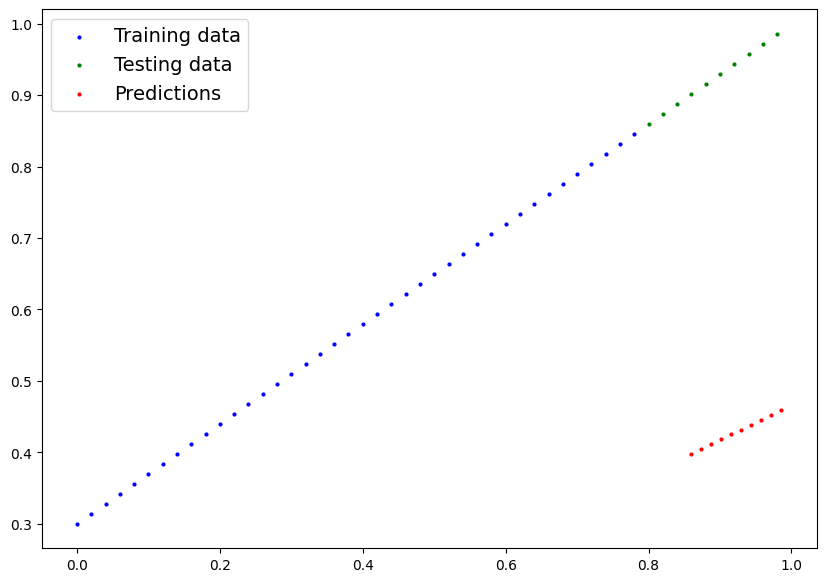

In [14]:
plot_predictions(predictions=y_preds)

In [15]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

The reason these predictions aren't close is because we are just using random parameter values to make the predictions. 

It has not yet looked at the blue dots to make a prediction about the green dots.

## 3. Train model

Right now the model is making predictions using random parameters, essentially guessing.

To fix that, we can update the model's internal parameters. 

We can hardcode them, since we know the values are `weight = 7, bias = 0.3`, but much of the time we won't have this prior information. Instead, we can let the model try to find out what they are.


### Creating a loss function and optimizer in PyTorch

In order for the model to update the parameters, we need to add a **loss function** and an **optimizer**.

**Loss Function**
- measures how wrong your predictions are
- many built-in loss functions in `torch.nn`
- Common values:
  * `torch.nn.L1Loss()` (mean absolute error, for regression problems)
  * `torch.nn.BCELoss()` (binary cross entropy, for binary classification problems)

**Optimizer**
- tells model how to update parameters to lower loss
- functions in `torch.optim`
- Common values:
  * `torch.optim.SGD()` (stochastic gradient descent)
  * `torch.optim.Adam()` (adam optimizer)
  
Use MAE in this case. MAE measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

For optimization, use SGD (`torch.optims.SGD(params, lr))`, where
- `params` is the target model parameters to optimize
- `lr` is the learning rate:
  * lower means smaller updates, which can sometimes be too small and take too much time
  * higher means larger updates, which can be too large and fail as a result
  * common startning values are `0.01`, `0.001`, `0.0001`, these can however be changed over time using **learning rate scheduling**

In [16]:
loss_fn = nn.L1Loss

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Creating an optimization loop

The training loop involves the model going through the training data and learning the relationships between `features` and `labels`

The testing loop involves going through testing data and evaluating how good the patterns are which we learned on the training data.

Each of these is called "loop", since we are looping through the samples in the datasets.

### PyTorch training loop

1. Forward Pass
   - go through all training data once, perform `forward()` calculation
2. Calculate Loss
   - compare predictions (output) to ground truth and see how wrong they are
3. Zero gradients
   - set optimizers gradients to zero so they can be recalculated
4. Perform backpropagation on the loss
   - compute gradient of loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`)
5. Update the optimizer (**gradient descent**)
   - update parameters with `requires_grad=True` with respect to loss gradients

### PyTorch testing loop

1. Forward Pass
   - go through all training data once, perform `forward()` calculation
2. Calculate the loss
   - compare predictions (output) to ground truth and see how wrong they are
3. Calculate evaluation metrics (optional)
   - alongside the loss value we might want other evaluation metrics

Notice how we don't have backpropagation or optimizer updating, since we don't want to change the model parameters during testing. We are only interested in the output of the forward pass through the model.